In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-2_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-2) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack ...

In [ ]:
import pyomo.environ as pyo
import numpy as np
model=pyo.ConcreteModel()

#dataset
#vertices_number = 8
arcs_number = 18
routes_number = 12

#a flexible Numpy array since routes contain various number of arcs
R = np.array([[0], [1,9,18], [3,5,11,18], [3,6,7,11,18],
                      [3,6,12,17], [1,9,15,17], [5,8,12,14],
                      [5,11], [4,1,9], [16,14,10,2], [16,13,2],
                      [13,2,3,5], [14,10,2,3,6,7]], dtype=object)

#Index sets for vertices, arcs and routes
model.Aset=pyo.Set(initialize=range(1,arcs_number+1))
model.Rset=pyo.Set(initialize=range(1,routes_number+1))

#Parameters
def rule_rho1(model, a, i):
    #check if Ri contains a
    return int(a in R[i])
model.rho1 = pyo.Param(model.Aset, model.Rset, initialize=rule_rho1)


def rule_rho2(model, a, i, j):
    #check if either of Ri or Rj(not both) contain a
    #using exclusive-OR
    t1 = a in R[i]
    t2 = a in R[j]
    t = (t1 != t2)
    return int(t)
model.rho2 = pyo.Param(model.Aset, model.Rset, model.Rset, initialize=rule_rho2)

#print(model.rho2)
def rule_sigma(model, a, b, i, j):
    #check if Ri and Rj contain both of a and b but in a different order
    if (a in R[i]) and (a in R[j]) and (b in R[i]) and (b in R[j]):
        if (R[i].index(a) - R[i].index(b)) * (R[j].index(a) - R[j].index(b)) < 0:
          return 1
    return 0
model.sigma = pyo.Param(model.Aset, model.Aset, model.Rset, model.Rset, initialize=rule_sigma)

#print(R[1].index(1) - R[1].index(9))

# for a in model.Aset:
#  for i in model.Rset:
#    if model.rho1[a, i]==1:
#     print("A = ", a, "Ri = ", i, "rho1 = ", model.rho1[a, i])

# for a in model.Aset:
#  for i in model.Rset:
#    for j in model.Rset:
#      if i < j and model.rho2[a, i, j]==1 :
#         print("A = ", a, "Ri = ", i, "Rj", j, "rho2 = ", model.rho2[a, i, j])

# for a in model.Aset:
#   for b in model.Aset:
#     for i in model.Rset:
#       for j in model.Rset:
#         if i < j and model.sigma[a, b, i, j]==1 :
#           print("a = ", a, "b = ", b , "Ri = ", i, "Rj = ", j, "sigma = ", model.sigma[a, b, i, j])

#ِDecision variables
model.x = pyo.Var(model.Aset, domain=pyo.Binary)
model.y = pyo.Var(model.Aset, model.Aset, domain=pyo.Binary)

#Objective function
def rule_obj(model):
    return sum(model.x[a] for a in model.Aset)
model.obj=pyo.Objective(rule=rule_obj, sense=pyo.minimize)

#Constraints
def rule_const1(model, Ri):
    return sum(model.rho1[a, Ri]*model.x[a] for a in model.Aset) >= 1
model.const1=pyo.Constraint(model.Rset, rule=rule_const1)


def rule_const2(model, Ri, Rj):
 if Rj <= Ri:
   return pyo.Constraint.Skip
 if not any(model.rho2[a, Ri, Rj] for a in model.Aset) and not any(model.sigma[a, b, Ri, Rj] for a in model.Aset for b in model.Aset if a!=b):
     return pyo.Constraint.Skip
 return  sum(model.rho2[a, Ri, Rj]*model.x[a] for a in model.Aset) + sum(model.sigma[a, b, Ri, Rj]*model.y[a, b] for a in model.Aset   for b in model.Aset if a != b) >= 1
model.const2=pyo.Constraint(model.Rset, model.Rset, rule=rule_const2)

# def rule_const2(model, Ri, Rj):
#   if Rj <= Ri:
#     return pyo.Constraint.Skip
#   else:
#     return (sum(model.rho2[a, Ri, Rj]*model.x[a] for a in model.Aset)  \
#     + sum(model.sigma[a, b, Ri, Rj]*model.y[a, b] for a in model.Aset \
#       for b in model.Aset if a != b)) >= 1
# model.const2=pyo.Constraint(model.Rset, model.Rset, rule=rule_const2)

def rule_const3(model, a, b):
  if a==b:
    return pyo.Constraint.Skip
  return 2*model.y[a, b] - model.x[a] - model.x[b] <= 0
model.const3=pyo.Constraint(model.Aset, model.Aset, rule=rule_const3)

def rule_const4(model, a, b):
  if a==b:
    return pyo.Constraint.Skip
  return   1 - model.x[a] + 1 - model.x[b] + model.y[a, b] >= 1
model.const4=pyo.Constraint(model.Aset, model.Aset, rule=rule_const4)


#linear equivalent of binary value for x and y
#def rule_const4(model, a):
#    return model.x[a]*(1-model.x[a]) == 0
#model.const4=pyo.Constraint(model.Aset, rule=rule_const4)

# def rule_const5(model, a, b):
#  if a==b:
#    return pyo.Constraint.Skip
#  return model.y[a, b]*(1-model.y[a, b])==0
# model.const5=pyo.Constraint(model.Aset, model.Aset, rule=rule_const5)

result=pyo.SolverFactory('glpk').solve(model, 'glpk')
print(result)

print("Optimal value of x")
list_a_has_sensors = []
for a in model.Aset:
  if pyo.value(model.x[a]) == 1:
    list_a_has_sensors.append(a)
    print (a,": ", pyo.value(model.x[a]))

# print("Optimal value of y")
# for a in model.Aset:
#     for b in model.Aset:
#         if  a < b and pyo.value(model.y[a, b]) == 1:
#             print("(", a , ", " , b, ")", pyo.value(model.y[a, b]))




Problem: 
- Name: unknown
  Lower bound: 7.0
  Upper bound: 7.0
  Number of objectives: 1
  Number of constraints: 691
  Number of variables: 325
  Number of nonzeros: 2297
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 39
      Number of created subproblems: 39
  Error rc: 0
  Time: 0.06374263763427734
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimal value of x
1 :  1.0
5 :  1.0
13 :  1.0
14 :  1.0
16 :  1.0
17 :  1.0
18 :  1.0


In [ ]:
# Check whether the code is working correctly or not
for i in model.Rset:
  print("\n", i, " :", end=' ')
  for a in list_a_has_sensors:
    if a in R[i]:
      print(a, end= ',')



 1  : 1,18,
 2  : 5,18,
 3  : 18,
 4  : 17,
 5  : 1,17,
 6  : 5,14,
 7  : 5,
 8  : 1,
 9  : 14,16,
 10  : 13,16,
 11  : 5,13,
 12  : 14,

In [ ]:
!pip install igraph
!pip install --upgrade python-igraph
!pip install python-igraph leidenalg cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=8ff8c7c070a3bb9e321c1b855615204181fb1c754f7f6eda284b78d7b4e163c8
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependenci

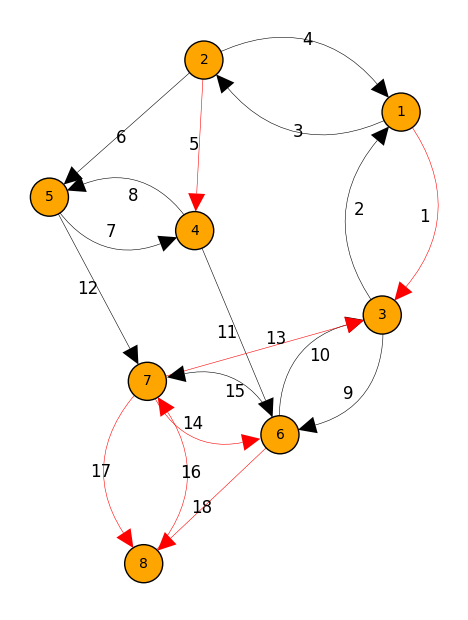

In [ ]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import time
import imageio
from IPython.display import Image

edges = [(0, 2), (2, 0), (0, 1), (1, 0), (1, 3), (1, 4), (4, 3), (3, 4), (2, 5), (5, 2), (3, 5), (4, 6), (6, 2), (6, 5), (5, 6), (7, 6), (6, 7), (5, 7)]
vertices = [1, 2, 3, 4, 5, 6, 7, 8]

g = ig.Graph(directed=True)
g.add_vertices(vertices)
g.add_edges(edges)
#g.es['weight'] = weights
g.ecount()

# print(g)
# print()
# print(g.get_adjacency())

colors = ['black']*18
for i in range(1, arcs_number+1):
    if i in list_a_has_sensors:
      colors[i-1] = 'red'
def show_my_graph(g, w=6, h=6):
    """ w, h: width, height in inches """

    fig, ax = plt.subplots()
    layout = g.layout("kk")
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    visual_style = {}
    visual_style["vertex_size"] = 0.2
    visual_style["vertex_color"] = ['orange' for v in g.vs['name']]
    visual_style["edge_color"] = colors
    visual_style["vertex_label"] = g.vs["name"]
    visual_style["edge_label"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13, 14, 15, 16, 17, 18]
    visual_style["edge_width"] = [0.4]
    visual_style["layout"] = layout
    visual_style["bbox"] = (300, 300)
    visual_style["margin"] = 10
    visual_style["autocurve"] = True
    visual_style["vertex_label_size"] = 10

    ig.plot(g, target=ax, **visual_style)


show_my_graph(g)